In [1]:
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.optim as optim
import torch.nn.functional as F

import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader

from model import Network

import warnings
warnings.filterwarnings("ignore", category=UserWarning)

torch.set_printoptions(linewidth=120)

%load_ext autoreload
%autoreload 2

In [2]:
def imshow(img):
    npimg = img.numpy()
    plt.subplots(figsize=(20, 20))
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

### Loading data

In [3]:
train_set = torchvision.datasets.FashionMNIST(
    root='./data'
    ,train=True
    ,download=True
    ,transform=transforms.Compose([
        transforms.ToTensor()
    ])
)
test_set = torchvision.datasets.FashionMNIST(
    root='./data'
    ,train=False
    ,download=True
    ,transform=transforms.Compose([
        transforms.ToTensor()
    ])
)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

classes = np.array(torchvision.datasets.FashionMNIST.classes)
train_loader = DataLoader(train_set, shuffle=False, batch_size=500, num_workers=1)
test_loader = DataLoader(test_set, shuffle=False, batch_size=8, num_workers=1)

###  Dataset visualization

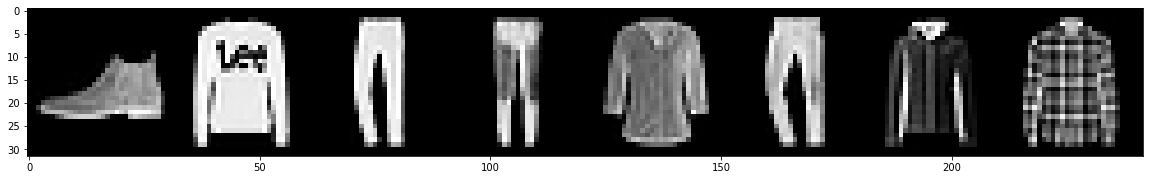

Ground truth vector ['Ankle boot' 'Pullover' 'Trouser' 'Trouser' 'Shirt' 'Trouser' 'Coat'
 'Shirt']


In [4]:
images, targets = next(iter(test_loader))
imshow(torchvision.utils.make_grid(images, nrow=10))
print(f'Ground truth vector {classes[targets]}')

In [5]:
def train(model, loader, optimizer, device):
    for batch, labels in loader:
        batch, labels = batch.to(device), labels.to(device)
        output = model(batch) #pass batch
        loss = F.cross_entropy(output, labels)
        
        optimizer.zero_grad() #set the gradients to zero
        loss.backward() #calculate gradients
        optimizer.step() #update weights
        
    return loss.item()

@torch.no_grad()
def evaluate(model, loader, device):
    correct, total = 0, 0
    model.eval()
    
    for batch, labels in loader:
        batch, labels = batch.to(device), labels.to(device)
        output = model(batch)
        correct += output.argmax(dim=1).eq(labels).sum().item() #sum up the the correct predictions
        total += labels.size(0)
            
    return 100 * correct / total 

def train_stats(epoch, train_loss, train_accuracy, test_accuracy):
    print(f"""
            Epoch {epoch}:
            Train loss = {train_loss}, Train accuracy = {train_accuracy} || Test accuracy = {test_accuracy}
            """
         )
    
@torch.no_grad()
def predict(model, loader, device):
    for batch, labels in loader:
        batch, labels = batch.to(device), labels.to(device)
        output = model(batch)
        yield output.argmax(dim=1)

### Train/Test

In [6]:
network = Network()
network.to(device)
optimizer = optim.Adam(network.parameters(), lr=0.01)

for epoch in range(10):
    train_loss = train(network, train_loader, optimizer, device)
    train_accuracy = evaluate(network, train_loader, device)
    test_accuracy = evaluate(network, test_loader, device)
    train_stats(epoch, train_loss, train_accuracy, test_accuracy)


            Epoch 0:
            Train loss = 0.3415835201740265, Train accuracy = 85.52166666666666 || Test accuracy = 84.77
            

            Epoch 1:
            Train loss = 0.3294743597507477, Train accuracy = 88.54166666666667 || Test accuracy = 87.33
            

            Epoch 2:
            Train loss = 0.31111836433410645, Train accuracy = 89.575 || Test accuracy = 87.96
            

            Epoch 3:
            Train loss = 0.2877389192581177, Train accuracy = 89.92666666666666 || Test accuracy = 88.28
            

            Epoch 4:
            Train loss = 0.2920975685119629, Train accuracy = 90.38666666666667 || Test accuracy = 88.66
            

            Epoch 5:
            Train loss = 0.2861175239086151, Train accuracy = 90.78333333333333 || Test accuracy = 88.75
            

            Epoch 6:
            Train loss = 0.27454856038093567, Train accuracy = 90.96166666666667 || Test accuracy = 88.61
            

            Epoch 7:
       

### Inference

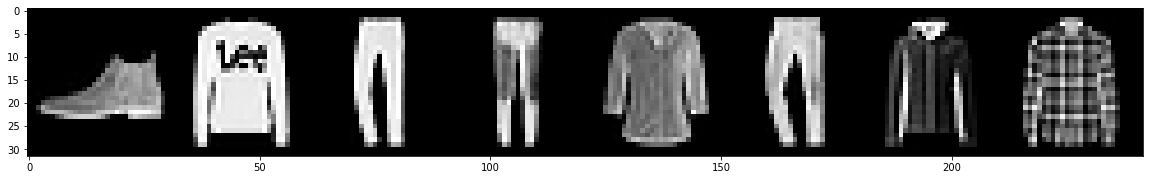

Predictions ['Ankle boot' 'Pullover' 'Trouser' 'Trouser' 'Shirt' 'Trouser' 'Coat'
 'Shirt']


In [7]:
preds = next(predict(network, test_loader, device))
imshow(torchvision.utils.make_grid(images, nrow=10))
print(f'Predictions {classes[preds.cpu()]}')

### Confusion matrix

Confusion matrix, without normalization


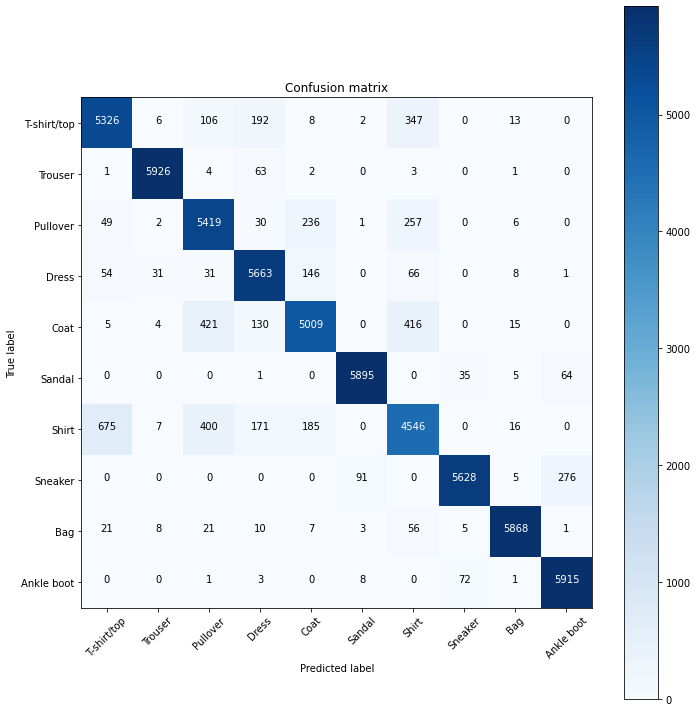

In [8]:
from plotcm import plot_confusion_matrix
from sklearn.metrics import confusion_matrix

# getting all predictions on train_set
all_preds = torch.Tensor([]).to(device)
for batch in predict(network, train_loader, device):
    all_preds = torch.cat(
        (all_preds, batch),
        dim=0
    )
cm = confusion_matrix(train_set.targets, all_preds.cpu())
plot_confusion_matrix(cm, classes)